In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('uplift').getOrCreate()
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.types import StringType,IntegerType,DoubleType,BooleanType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler # Data preprocessing    
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator    
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics 


In [0]:
data= spark.read.csv('/FileStore/tables/HR_comma_sep.csv',header=True, inferSchema=True)

In [0]:
data.show()

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
 0.38| 0.53| 2| 157| 3| 0| 1| 0| sales| low|
 0.8| 0.86| 5| 262| 6| 0| 1| 0| sales|medium|
 0.11| 0.88| 7| 272| 4| 0| 1| 0| sales|medium|
 0.72| 0.87| 5| 223| 5| 0| 1| 0| sales| low|
 0.37| 0.52| 2| 159| 3| 0| 1| 0| sales| low|
 0.41| 0.5| 2| 153| 3| 0| 1| 0| sales| low|
 0.1| 0.77| 6| 247| 4| 0| 1| 0| sales| low|
 0.92| 0.85| 5| 259| 5| 0| 1| 0| sales| low|
 0.89| 1.0| 5| 224| 5| 0| 1| 0| sales| low|
 0.42| 0.53| 2| 142| 3| 0| 1| 0| sales| low|
 0.45| 0.54| 2| 135| 3| 0| 1| 0| sales| low|
 0.11| 0.81| 6| 305| 4| 0| 1| 0| sales| low|
 0.84| 0.92| 4| 234| 5| 0| 1| 0| sales| low|
 0.41| 0.55| 2| 148| 3| 0| 1| 0| sales| low|
 0.36| 0.56| 2| 137| 3| 0| 1| 0| sales| low|
 0.38| 0.54| 2| 143| 3| 0| 1| 0| sales| low|
 0.45| 0.47| 2| 160| 3| 0| 1| 0| sales| low|
 0.78| 0.99| 4| 255| 6| 0| 1| 0| sales| low|
 0.45| 0.51| 2| 160| 3| 1| 1| 1| sales| low|
 0.76| 0.89| 5| 262| 5| 0| 1| 0| sales| low|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
only showing top 20 rows

In [0]:
data.printSchema()

root
-- satisfaction_level: double (nullable = true)
-- last_evaluation: double (nullable = true)
-- number_project: integer (nullable = true)
-- average_montly_hours: integer (nullable = true)
-- time_spend_company: integer (nullable = true)
-- Work_accident: integer (nullable = true)
-- left: integer (nullable = true)
-- promotion_last_5years: integer (nullable = true)
-- Department: string (nullable = true)
-- salary: string (nullable = true)

In [0]:
data.describe().show()

+-------+-------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+---------------------+----------+------+
summary| satisfaction_level| last_evaluation| number_project|average_montly_hours|time_spend_company| Work_accident| left|promotion_last_5years|Department|salary|
+-------+-------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+---------------------+----------+------+
 count| 14999| 14999| 14999| 14999| 14999| 14999| 14999| 14999| 14999| 14999|
 mean| 0.6128335222348166| 0.7161017401159978| 3.80305353690246| 201.0503366891126| 3.498233215547703| 0.1446096406427095| 0.2380825388359224| 0.021268084538969265| null| null|
 stddev|0.24863065106114257|0.17116911062327556|1.2325923553183513| 49.94309937128406|1.4601362305354808|0.35171855238017957|0.42592409938029885| 0.1442814645785825| null| null|
 min| 0.09| 0.36| 2| 96| 2| 0| 0| 0| IT| high|
 max| 1.0| 1.0| 7| 310| 10| 1| 1| 1| technical|medium|
+-------+-------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+---------------------+----------+------+

In [0]:
data.select('last_evaluation','number_project','left').show()

+---------------+--------------+----+
last_evaluation|number_project|left|
+---------------+--------------+----+
 0.53| 2| 1|
 0.86| 5| 1|
 0.88| 7| 1|
 0.87| 5| 1|
 0.52| 2| 1|
 0.5| 2| 1|
 0.77| 6| 1|
 0.85| 5| 1|
 1.0| 5| 1|
 0.53| 2| 1|
 0.54| 2| 1|
 0.81| 6| 1|
 0.92| 4| 1|
 0.55| 2| 1|
 0.56| 2| 1|
 0.54| 2| 1|
 0.47| 2| 1|
 0.99| 4| 1|
 0.51| 2| 1|
 0.89| 5| 1|
+---------------+--------------+----+
only showing top 20 rows

In [0]:
from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()


+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+

In [0]:
data.columns

Out[8]: ['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'Department',
 'salary']

In [0]:
from pyspark.sql.types import IntegerType,FloatType
data= data.withColumn("satisfaction_level", data["satisfaction_level"].cast(FloatType()))
data= data.withColumn("last_evaluation", data["last_evaluation"].cast(FloatType()))



In [0]:
data.printSchema()

root
-- satisfaction_level: float (nullable = true)
-- last_evaluation: float (nullable = true)
-- number_project: integer (nullable = true)
-- average_montly_hours: integer (nullable = true)
-- time_spend_company: integer (nullable = true)
-- Work_accident: integer (nullable = true)
-- left: integer (nullable = true)
-- promotion_last_5years: integer (nullable = true)
-- Department: string (nullable = true)
-- salary: string (nullable = true)

In [0]:
data_p=data.toPandas()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

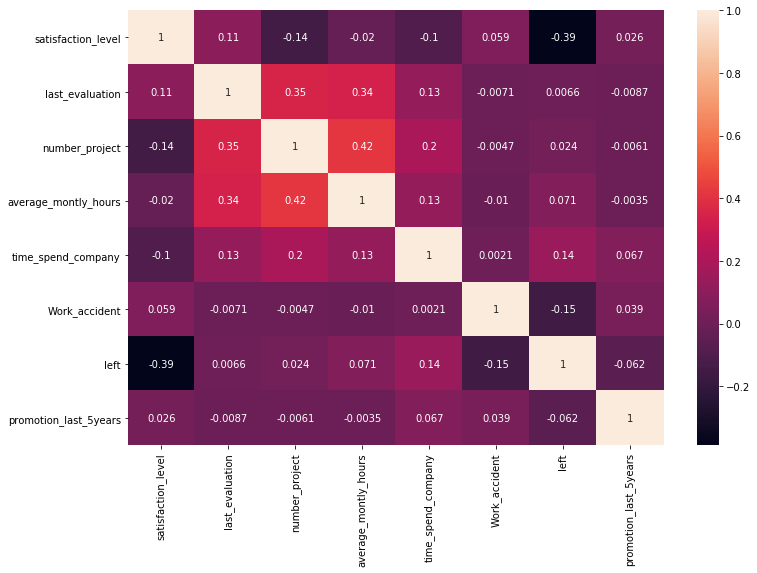

In [0]:
plt.figure(figsize=(12,8))
sns.heatmap(data_p.corr(),annot=True)

In [0]:
data_p.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


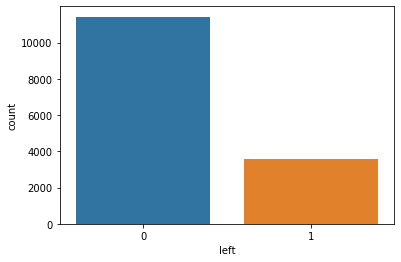

In [0]:
sns.countplot(data_p.left)

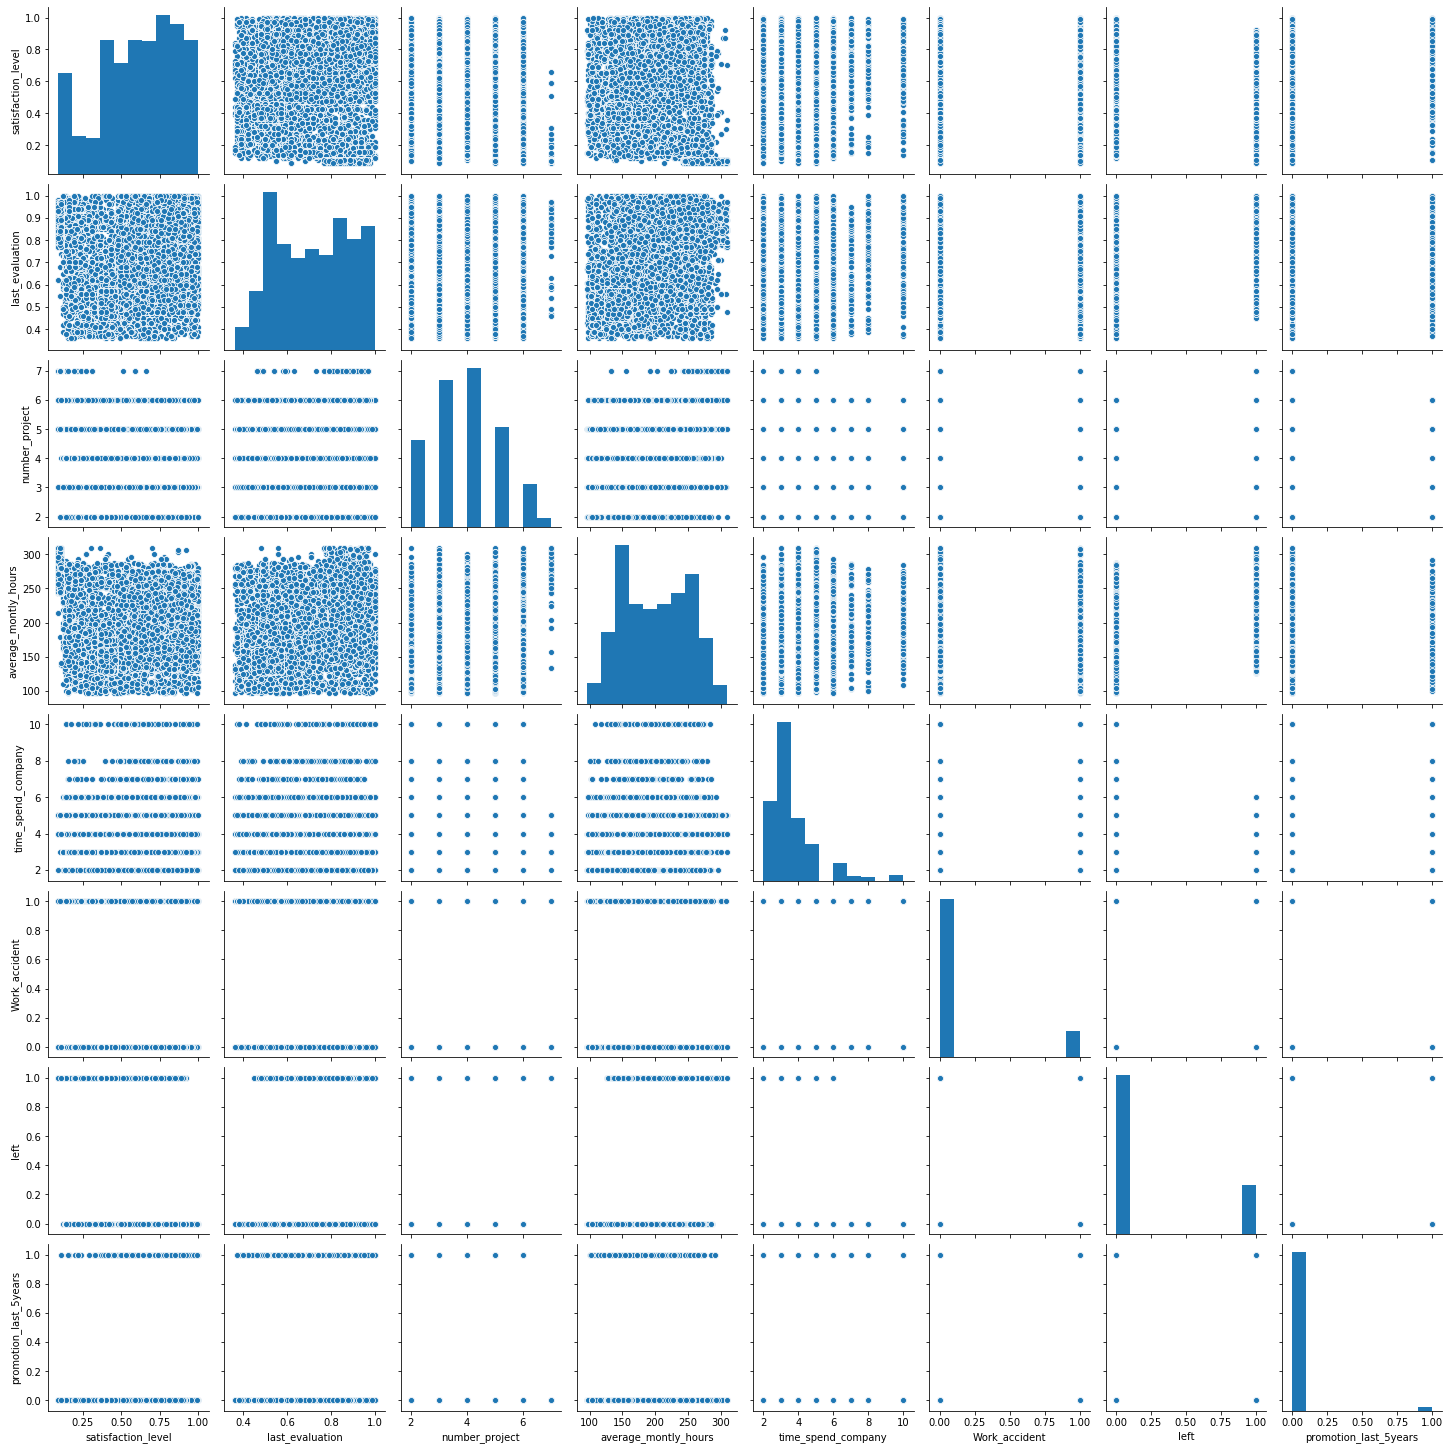

In [0]:
sns.pairplot(data_p)

In [0]:
data.printSchema()

root
-- satisfaction_level: float (nullable = true)
-- last_evaluation: float (nullable = true)
-- number_project: integer (nullable = true)
-- average_montly_hours: integer (nullable = true)
-- time_spend_company: integer (nullable = true)
-- Work_accident: integer (nullable = true)
-- left: integer (nullable = true)
-- promotion_last_5years: integer (nullable = true)
-- Department: string (nullable = true)
-- salary: string (nullable = true)

In [0]:
def categoricalToNumeric(df, string_column):
    '''
    Convert categorical vars to numeric vars
    '''
    index_column = string_column + 'Index'
    vec_column = string_column + 'Vec' 
    
    indexer = StringIndexer(inputCol = string_column, outputCol = index_column)
    df = indexer.setHandleInvalid("skip").fit(df).transform(df)
    encoder = OneHotEncoder(inputCols = [index_column], outputCols = [vec_column])
    df = encoder.fit(df).transform(df)
    return df

In [0]:
category_column = ['Department', 'salary']
f_data1 = data
for each_column in category_column:
        f_data1 = categoricalToNumeric(f_data1,each_column)
f_data1.show()

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+
satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|DepartmentIndex|DepartmentVec|salaryIndex| salaryVec|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+
 0.38| 0.53| 2| 157| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.8| 0.86| 5| 262| 6| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])|
 0.11| 0.88| 7| 272| 4| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])|
 0.72| 0.87| 5| 223| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.37| 0.52| 2| 159| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.41| 0.5| 2| 153| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.1| 0.77| 6| 247| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.92| 0.85| 5| 259| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.89| 1.0| 5| 224| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.42| 0.53| 2| 142| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.45| 0.54| 2| 135| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.11| 0.81| 6| 305| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.84| 0.92| 4| 234| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.41| 0.55| 2| 148| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.36| 0.56| 2| 137| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.38| 0.54| 2| 143| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.45| 0.47| 2| 160| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.78| 0.99| 4| 255| 6| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.45| 0.51| 2| 160| 3| 1| 1| 1| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
 0.76| 0.89| 5| 262| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+
only showing top 20 rows

In [0]:
def tc(x,y):
    #CR
    if x == 0 and y == 0:
      return 0
    #TR
    elif x == 1 and y == 0:
      return 1
    #TN
    elif x == 1 and y == 1:
      return 2
    #CN
    else:
      return 3

In [0]:
from pyspark.sql.functions import udf, array
spark_udf = udf(tc,IntegerType())
f_data1 = f_data1.withColumn('Target_class',spark_udf(f_data1.promotion_last_5years,f_data1.left))
f_data1.show(200)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----------+------+---------------+-------------+-----------+-------------+------------+
satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years| Department|salary|DepartmentIndex|DepartmentVec|salaryIndex| salaryVec|Target_class|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----------+------+---------------+-------------+-----------+-------------+------------+
 0.38| 0.53| 2| 157| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.8| 0.86| 5| 262| 6| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])| 3|
 0.11| 0.88| 7| 272| 4| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])| 3|
 0.72| 0.87| 5| 223| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.37| 0.52| 2| 159| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.41| 0.5| 2| 153| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.1| 0.77| 6| 247| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.92| 0.85| 5| 259| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.89| 1.0| 5| 224| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.42| 0.53| 2| 142| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.54| 2| 135| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.11| 0.81| 6| 305| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.84| 0.92| 4| 234| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.41| 0.55| 2| 148| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.36| 0.56| 2| 137| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.38| 0.54| 2| 143| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.47| 2| 160| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.78| 0.99| 4| 255| 6| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.51| 2| 160| 3| 1| 1| 1| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 2|
 0.76| 0.89| 5| 262| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.11| 0.83| 6| 282| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.38| 0.55| 2| 147| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.09| 0.95| 6| 304| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.46| 0.57| 2| 139| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.4| 0.53| 2| 158| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.89| 0.92| 5| 242| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.82| 0.87| 4| 239| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.4| 0.49| 2| 135| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.41| 0.46| 2| 128| 3| 0| 1| 0| accounting| low| 7.0|(9,[7],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.38| 0.5| 2| 132| 3| 0| 1| 0| accounting| low| 7.0|(9,[7],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.09| 0.62| 6| 294| 4| 0| 1| 0| accounting| low| 7.0|(9,[7],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.57| 2| 134| 3| 0| 1| 0| hr| low| 8.0|(9,[8],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.4| 0.51| 2| 145| 3| 0| 1| 0| hr| low| 8.0|(9,[8],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.55| 2| 140| 3| 0| 1| 0| hr| low| 8.0|(9,[8],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.84| 0.87| 4| 246| 6| 0| 1| 0| hr| low| 8.0|(9,[8],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.1| 0.94| 6| 255| 4| 0| 1| 0| technical| low| 1.0|(9,[1],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.38| 0.46| 2| 137| 3| 0| 1| 0| technical| low| 1.0|(9,[1],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.45| 0.5| 2| 126| 3| 0| 1| 0| technical| low| 1.0|(9,[1],[1.0])| 0.0|(2,[0],[1.0])| 3|
 0.11| 0.89| 6| 306| 4| 0| 1| 0| technical| low| 1.0|(9,[1],[1.0

In [0]:
from pyspark.sql.functions import col,log10
f_data1 = f_data1.withColumn("time_spent", log10(f_data1.time_spend_company))
f_data1.show()

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+------------+-------------------+
satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|Department|salary|DepartmentIndex|DepartmentVec|salaryIndex| salaryVec|Target_class| time_spent|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+------------+-------------------+
 0.38| 0.53| 2| 157| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.8| 0.86| 5| 262| 6| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])| 3| 0.7781512503836436|
 0.11| 0.88| 7| 272| 4| 0| 1| 0| sales|medium| 0.0|(9,[0],[1.0])| 1.0|(2,[1],[1.0])| 3| 0.6020599913279624|
 0.72| 0.87| 5| 223| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6989700043360189|
 0.37| 0.52| 2| 159| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.41| 0.5| 2| 153| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.1| 0.77| 6| 247| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6020599913279624|
 0.92| 0.85| 5| 259| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6989700043360189|
 0.89| 1.0| 5| 224| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6989700043360189|
 0.42| 0.53| 2| 142| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.45| 0.54| 2| 135| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.11| 0.81| 6| 305| 4| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6020599913279624|
 0.84| 0.92| 4| 234| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6989700043360189|
 0.41| 0.55| 2| 148| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.36| 0.56| 2| 137| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.38| 0.54| 2| 143| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.45| 0.47| 2| 160| 3| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3|0.47712125471966244|
 0.78| 0.99| 4| 255| 6| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.7781512503836436|
 0.45| 0.51| 2| 160| 3| 1| 1| 1| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 2|0.47712125471966244|
 0.76| 0.89| 5| 262| 5| 0| 1| 0| sales| low| 0.0|(9,[0],[1.0])| 0.0|(2,[0],[1.0])| 3| 0.6989700043360189|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+----------+------+---------------+-------------+-----------+-------------+------------+-------------------+
only showing top 20 rows

In [0]:
f_data1.columns

Out[23]: ['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'Department',
 'salary',
 'DepartmentIndex',
 'DepartmentVec',
 'salaryIndex',
 'salaryVec',
 'Target_class',
 'time_spent']

In [0]:
col = ['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spent',
 'Work_accident',
 'DepartmentVec',
 'salaryVec']

In [0]:
assembler  = VectorAssembler(inputCols=col,outputCol='features')
f_data1=assembler.transform(f_data1)
final=f_data1.select(['features','Target_class'])

In [0]:
final.show()

+--------------------+------------+
 features|Target_class|
+--------------------+------------+
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,5,...| 2|
(17,[0,1,2,3,4,6,...| 3|
+--------------------+------------+
only showing top 20 rows

In [0]:
t_Data=final.toDF('features','label')
t_Data.show()

+--------------------+-----+
 features|label|
+--------------------+-----+
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,6,...| 3|
(17,[0,1,2,3,4,5,...| 2|
(17,[0,1,2,3,4,6,...| 3|
+--------------------+-----+
only showing top 20 rows

In [0]:

t_Data.groupBy("label").count().show()


+-----+-----+
label|count|
+-----+-----+
 1| 300|
 3| 3552|
 2| 19|
 0|11128|
+-----+-----+

In [0]:
train_data,test_data =  t_Data.randomSplit([0.7,0.3])

In [0]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True).fit(train_data)

# Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(train_data)

# Normalize each feature to have unit standard deviation.
t_scaledData = scaler.transform(train_data)
t_scaledData.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
features |label|scaledFeatures |
+---------------------------------------------------------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
(17,[0,1,2,3,4],[0.14000000059604645,0.7599999904632568,4.0,142.0,1.0]) |0 |[-1.899136938107474,0.25730636326862427,0.15303952718616243,-1.1805077019115298,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.14000000059604645,0.7900000214576721,5.0,271.0,0.6020599913279624]) |0 |[-1.899136938107474,0.4326219295062325,0.9600171848676311,1.3915369060128302,0.5575483450390932,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.14000000059604645,0.7900000214576721,5.0,271.0,0.6020599913279624]) |0 |[-1.899136938107474,0.4326219295062325,0.9600171848676311,1.3915369060128302,0.5575483450390932,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.15000000596046448,0.7400000095367432,6.0,144.0,0.8450980400142568]) |1 |[-1.858998619546503,0.14042955132380222,1.7669948425490998,-1.1406310413235552,2.0945813778613687,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.15000000596046448,0.7400000095367432,6.0,144.0,0.8450980400142568]) |1 |[-1.858998619546503,0.14042955132380222,1.7669948425490998,-1.1406310413235552,2.0945813778613687,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.2199999988079071,0.9399999976158142,3.0,193.0,1.0]) |1 |[-1.5780305690518739,1.3091987157331482,-0.6539381304953062,-0.16365285691817813,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.23999999463558197,0.6499999761581421,6.0,210.0,0.6989700043360189]) |0 |[-1.4977539917406548,-0.38551679906864733,1.7669948425490998,0.17529875807960574,1.1704313566077222,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
(17,[0,1,2,3,4],[0.23999999463558197,0.810000002384185

In [0]:
t_scaledData.groupBy('label').count().show()

major_df = t_scaledData.filter((t_scaledData.label) == 0)
minor_df1 = t_scaledData.filter((t_scaledData.label) == 1)
minor_df2 = t_scaledData.filter((t_scaledData.label) == 2)
minor_df3 = t_scaledData.filter((t_scaledData.label) == 3)


ratio1 = int(major_df.count()/minor_df1.count())
ratio2 = int(major_df.count()/minor_df2.count())
ratio3 = int(major_df.count()/minor_df3.count())

print(ratio1,ratio2,ratio3)

+-----+-----+
label|count|
+-----+-----+
 1| 214|
 3| 2496|
 2| 12|
 0| 7766|
+-----+-----+

36 647 3

In [0]:
from pyspark.sql.functions import col, explode, array, lit
a=range(ratio1)
b=range(ratio2)
c=range(ratio3)
oversampled_df1 = minor_df1.withColumn("dummy1", explode(array([lit(x) for x in a]))).drop('dummy1')
oversampled_df2 = minor_df2.withColumn("dummy2", explode(array([lit(x) for x in b]))).drop('dummy2')
oversampled_df3 = minor_df3.withColumn("dummy2", explode(array([lit(x) for x in c]))).drop('dummy2')
combined_df1 = major_df.unionAll(oversampled_df1)
combined_df2 = combined_df1.unionAll(oversampled_df2)
combined_df3 = combined_df2.unionAll(oversampled_df3)
combined_df3.groupBy('label').count().show()


+-----+-----+
label|count|
+-----+-----+
 0| 7766|
 1| 7704|
 2| 7764|
 3| 7488|
+-----+-----+

In [0]:
train_scaledData1= combined_df3.select('label','scaledFeatures')
train_scaledData=train_scaledData1.toDF('label','features')
train_scaledData.show(truncate=False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
label|features |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
0 |[-1.899136938107474,0.25730636326862427,0.15303952718616243,-1.1805077019115298,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.899136938107474,0.4326219295062325,0.9600171848676311,1.3915369060128302,0.5575483450390932,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.899136938107474,0.4326219295062325,0.9600171848676311,1.3915369060128302,0.5575483450390932,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.4977539917406548,-0.38551679906864733,1.7669948425490998,0.17529875807960574,1.1704313566077222,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.4977539917406548,0.5494987414510546,1.7669948425490998,1.232030263660932,2.0945813778613687,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.4977539917406548,0.5494987414510546,1.7669948425490998,1.232030263660932,2.0945813778613687,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.4576156731796834,1.017006337550718,0.15303952718616243,-0.9412477383836823,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.4576156731796834,1.017006337550718,0.15303952718616243,-0.9412477383836823,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.1365092443133598,1.4845142819707564,0.9600171848676311,-1.4197676654393772,0.5575483450390932,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |
0 |[-1.1365092443133598,1.4845142819707564,0.9600171848676311,-1.4197676654393772,0.5575483450390932,-0.4162560271552513,-0.62584534502989

In [0]:
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
model = RandomForestClassifier(featuresCol='features',labelCol='label', maxDepth=15).fit(train_scaledData)

In [0]:
ts_scaledData1 = scaler.transform(test_data)
test_scaledData= ts_scaledData1.select('scaledFeatures','label')
test_scaledData=test_scaledData.toDF('features','label')

# test_scaledData=ts_scaledData.drop('features')
# test_scaledData=tr_scaledData.toDF('label','features')
test_scaledData.show(200,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
features |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
[-1.899136938107474,0.25730636326862427,0.15303952718616243,-1.1805077019115298,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-1.6583071463630932,-0.7361475832234886,1.7669948425490998,-1.758719280437161,-0.2325952817882898,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-1.6583071463630932,-0.7361475832234886,1.7669948425490998,-1.758719280437161,-0.2325952817882898,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-1.5780305690518739,1.3091987157331482,-0.6539381304953062,-0.16365285691817813,3.074219877404787,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |1 |
[-1.2569241401855502,-0.4439552050410584,-1.460915788176775,-1.2801993533814662,-0.2325952817882898,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-0.9358178309406735,-1.320531991267974,0.15303952718616243,-0.10383786603621627,-0.2325952817882898,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |1 |
[-0.8956795721904256,0.19886795729621326,1.7669948425490998,-0.3231594992700764,-0.2325952817882898,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |1 |
[-0.8956795721904256,1.1338834978159151,-1.460915788176775,0.21517541866758033,-1.3462401757579718,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-0.7351262979465404,0.25730636326862427,1.7669948425490998,-0.9412477383836823,-1.3462401757579718,-0.4162560271552513,-0.6258453450298901,-0.46791777477296176,-0.4110401665111487,-0.30337469413112533,-0.2523600815402349,-0.24501155359539428,-0.23206332249737238,-0.2309204002797919,-0.22838993021897713,-0.9754630550537958,-0.8680328729458193] |0 |
[-0.49429650620215937,0.37418317521344635,0.15303952718616243,1.0525852910150464,3.074219877404787,-0.416256027155251

In [0]:
predictions = model.transform(test_scaledData)
b_eval1 = MulticlassClassificationEvaluator(labelCol='label')
print(b_eval1.evaluate(predictions))

0.9590898460777671

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_true = test_scaledData.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
target_names = ["Class {}".format(i) for i in range(4)]
print(classification_report(y_true, y_pred, target_names = target_names))

precision recall f1-score support

 Class 0 0.97 0.97 0.97 3362
 Class 1 0.29 0.45 0.36 86
 Class 2 0.86 0.86 0.86 7
 Class 3 0.98 0.96 0.97 1056

 accuracy 0.96 4511
 macro avg 0.78 0.81 0.79 4511
weighted avg 0.96 0.96 0.96 4511

In [0]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(y_true,y_pred))

ROC AUC score: 0.8921955443267545

In [0]:
predictions=predictions.drop('label')
output = test_scaledData.join(predictions,['features'])
output.printSchema()

root
-- features: vector (nullable = true)
-- label: integer (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
split1_udf = udf(lambda value: value[0].item(), FloatType())
split2_udf = udf(lambda value: value[1].item(), FloatType())
split3_udf = udf(lambda value: value[2].item(), FloatType())
split4_udf = udf(lambda value: value[3].item(), FloatType())


output2 = output.select(split1_udf('probability').alias('CR'), split2_udf('probability').alias('TR'),split3_udf('probability').alias('TN'),split4_udf('probability').alias('CN'),'features','label','prediction')

In [0]:
output2.show(100)

+------------+-----------+---+------------+--------------------+-----+----------+
 CR| TR| TN| CN| features|label|prediction|
+------------+-----------+---+------------+--------------------+-----+----------+
 0.6686774| 0.3313226|0.0| 0.0|[-1.8991369381074...| 0| 0.0|
 0.75908154|0.106521934|0.0| 0.1343965|[-1.6583071463630...| 0| 0.0|
 0.75908154|0.106521934|0.0| 0.1343965|[-1.6583071463630...| 0| 0.0|
 0.75908154|0.106521934|0.0| 0.1343965|[-1.6583071463630...| 0| 0.0|
 0.75908154|0.106521934|0.0| 0.1343965|[-1.6583071463630...| 0| 0.0|
 0.01366036| 0.9863396|0.0| 0.0|[-1.5780305690518...| 1| 1.0|
 0.7411905| 0.0|0.0| 0.25880954|[-1.2569241401855...| 0| 0.0|
 0.08938033| 0.90108395|0.0| 0.00953571|[-0.9358178309406...| 1| 1.0|
 0.13158067| 0.86103046|0.0|0.0073888744|[-0.8956795721904...| 1| 1.0|
 0.94129276| 0.05|0.0| 0.008707229|[-0.8956795721904...| 0| 0.0|
 0.8400232| 0.1566862|0.0| 0.003290563|[-0.7351262979465...| 0| 0.0|
 0.33652613| 0.66222864|0.0|0.0012452069|[-0.4942965062021...| 0| 1.0|
 0.33652613| 0.66222864|0.0|0.0012452069|[-0.4942965062021...| 0| 1.0|
 0.33652613| 0.66222864|0.0|0.0012452069|[-0.4942965062021...| 0| 1.0|
 0.33652613| 0.66222864|0.0|0.0012452069|[-0.4942965062021...| 0| 1.0|
 0.76083845| 0.23605368|0.0|0.0031078497|[-0.4541582474519...| 0| 0.0|
 0.03618717| 0.9628853|0.0|9.2748733E-4|[-0.4541582474519...| 1| 1.0|
 0.94006586|0.043023255|0.0| 0.016910886|[-0.3337434712011...| 0| 0.0|
 0.75027174| 0.23270415|0.0| 0.017024143|[-0.3337434712011...| 0| 0.0|
 0.07639556| 0.922677|0.0|9.2748733E-4|[-0.3337434712011...| 1| 1.0|
 0.82406837| 0.16138527|0.0| 0.014546342|[-0.2534667144577...| 0| 0.0|
 0.82406837| 0.16138527|0.0| 0.014546342|[-0.2534667144577...| 0| 0.0|
 0.82406837| 0.16138527|0.0| 0.014546342|[-0.2534667144577...| 0| 0.0|
 0.82406837| 0.16138527|0.0| 0.014546342|[-0.2534667144577...| 0| 0.0|
 0.80991316| 0.18770592|0.0|0.0023809525|[-0.2133284557075...| 0| 0.0|
 0.90695304|0.093046956|0.0| 0.0|[-0.1731901969572...| 0| 0.0|
 0.8346995| 0.1600634|0.0|0.0052370927|[-0.1330519382070...| 0| 0.0|
 0.58599913| 0.3616217|0.0| 0.052379135|[-0.1330519382070...| 0| 0.0|
 0.8151558| 0.16282429|0.0| 0.022019904|[-0.1330519382070...| 0| 0.0|
 0.8838293| 0.11524321|0.0|9.2748733E-4|[-0.0929136794567...| 0| 0.0|
 0.84658986| 0.13253407|0.0| 0.020876074|[-0.0527751814636...| 0| 0.0|
 0.3968391| 0.60111594|0.0|0.0020449478|[-0.0126369227133...| 0| 1.0|
 0.6392833| 0.35849568|0.0|0.0022210286|[0.02750133603685...| 0| 0.0|
 0.6392833| 0.35849568|0.0|0.0022210286|[0.02750133603685...| 0| 0.0|
 0.6392833| 0.35849568|0.0|0.0022210286|[0.02750133603685...| 0| 0.0|
 0.6392833| 0.35849568|0.0|0.0022210286|[0.02750133603685...| 0| 0.0|
 0.7607415| 0.22793874|0.0| 0.011319808|[0.06763959478709...| 0| 0.0|
 0.544795| 0.45520502|0.0| 0.0|[0.26833112778123...| 0| 0.0|
 0.26622003| 0.7320065|0.0|0.0017734702|[0.26833112778123...| 0| 1.0|
 0.5541945| 0.4346094|0.0| 0.011196098|[0.30846938653147...| 0| 0.0|
 0.9177299|0.043023255|0.0| 0.039246857|[0.30846938653147...| 0| 0.0|
 0.4742051| 0.52379996|0.0|0.0019949276|[0.50916091952561...| 0| 1.0|
 0.4055974| 0.2875287|0.0| 0.30687392|[0.50916091952561...| 1| 0.0|
 0.4055974| 0.2875287|0.0| 0.30687392|[0.50916091952561...| 1| 0.0|
 0.4055974| 0.2875287|0.0| 0.30687392|[0.50916091952561...| 1| 0.0|
 0.4055974| 0.2875287|0.0| 0.30687392|[0.50916091952561...| 1| 0.0|
 0.82594913| 0.15660517|0.0| 0.01744568|[0.50916091952561...| 0| 0.0|
 0.3764798| 0.6235202|0.0| 0.0|[0.58943743702610...| 0| 1.0|
 0.3764798| 0.6235202|0.0| 0.0|[0.58943743702610...| 0| 1.0|
 0.3764798| 0.6235202|0.0| 0.0|[0.58943743702610...| 0| 1.0|
 0.3764798| 0.6235202|0.0| 0.0|[0.58943743702610...| 0| 1.0|
 0.9518589|0.043153983|0.0| 0.004987139|[0.58943743702610...| 0| 0.0|
 0.35331553| 0.64668447|0.0| 0.0|[0.62957569577635...| 0| 1.0|
 0.6810207| 0.263109|0.0| 0.055870324|[0.62957569577635...| 0| 0.0|
 0.73333335| 0.1|0.0| 0.16666667|[0.62957569577635...| 0| 0.0|
 0.11333458| 0.8860119|0.0|6.5349997E-4|[0

In [0]:
output = output2.withColumn('Uplift_Score', ( output2['cn'] + output2['tr']-output2['cr']-output2['tn'] ))
output=output.toPandas()
output1=output.drop('features',axis=1)
output1.head()


,CR,TR,TN,CN,label,prediction,Uplift_Score
0,0.668677,0.331323,0.0,0.000000,0,0.0,-0.337355
1,0.759082,0.106522,0.0,0.134396,0,0.0,-0.518163
2,0.759082,0.106522,0.0,0.134396,0,0.0,-0.518163
3,0.759082,0.106522,0.0,0.134396,0,0.0,-0.518163
4,0.759082,0.106522,0.0,0.134396,0,0.0,-0.518163


In [0]:
def sorting_data(df:pd.DataFrame):
    """Function to sort data
    """
    # Set up new DataFrames for ETP model and ETU model
    df_u = pd.DataFrame({'n':[], 'target_class':[]})
    df_u['target_class'] = df['label']
    
    
    # Add quantiles
    df_u['n'] = df.Uplift_Score.rank(pct=True, ascending=False)
    df_u['score'] = df['Uplift_Score']
    
    
    # Ranking the data by deciles
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    return df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Calculate the C, T, CR, and TR
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    

    # Calculate & add the qini value into the Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    qini_coef= df['uplift'].sum(skipna = True) - df['random'].sum(skipna = True)
    
    # Print the Qini coefficient
    print('Qini coefficient = {} {}'.format(round(qini_coef, 2), '%'))
    
    # Add q0 into the Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini


def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df = pd.DataFrame([df_u]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot the qini curve
    """
    print('Plotting the qini curve...')
    
    # Define the data that will be plotted
    order = ['ETU']
    ax = sns.lineplot(x='n', y=df.uplift, data=df)
    
    
    # Additional plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    print('Successfully plot the qini curve')
    return ax




In [0]:
def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_u = sorting_data(prediction_results)
    print('ETU model:')
    qini_u = calculating_qini(df_u)
    qini = qini_u
    ax = plot_qini(qini)
    return ax, qini

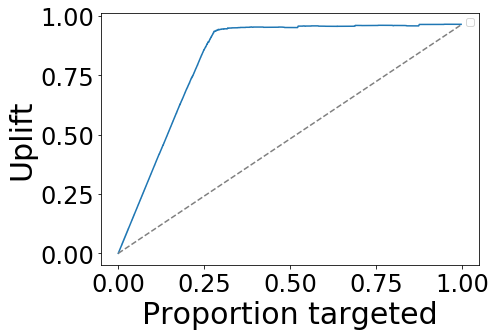

In [0]:
print(ax, qini_1 = evaluation_qini(output1))
plt.title('Qini Curve',fontsize=10)